### MAT 653
#### Wei Li

## Gibbs sampling (Bivariate normal distribution)


Sample Means: [0.03157383 1.98761775]
Sample Covariance Matrix:
 [[ 1.00340439 -0.37571629]
 [-0.37571629  0.24883436]]
Sample Correlation Matrix:
 [[ 1.         -0.75191171]
 [-0.75191171  1.        ]]


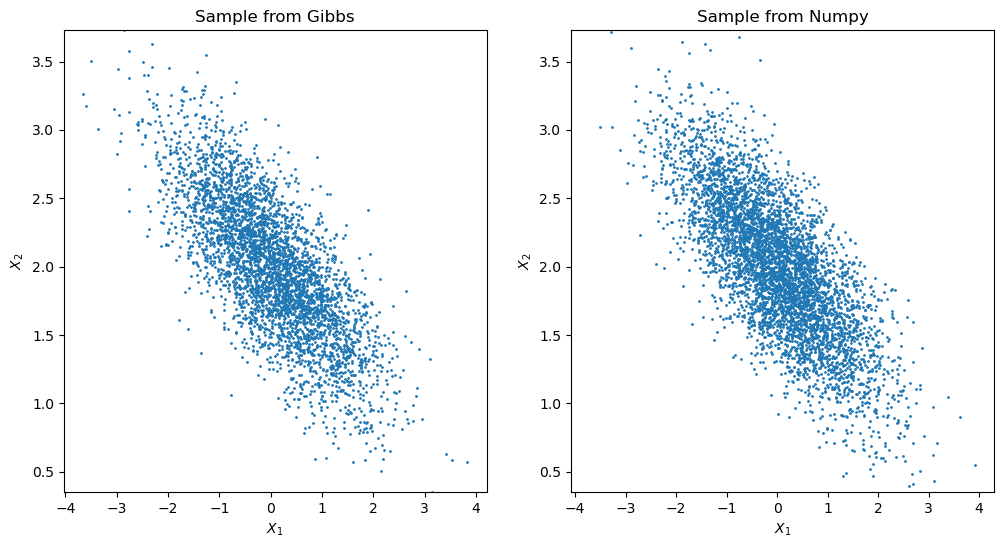

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
np.random.seed(2023) 

# Initialize constants and parameters
N = 5000               # Length of chain
burn = 1000            # Burn-in length
X = np.zeros((N, 2))   # The chain, a bivariate sample

rho = -0.75            # Correlation
mu1 = 0
mu2 = 2
sigma1 = 1
sigma2 = 0.5
s1 = np.sqrt(1 - rho**2) * sigma1
s2 = np.sqrt(1 - rho**2) * sigma2

# Generate the chain
X[0, :] = [mu1, mu2]   # Initialize
for i in range(1, N):
    x2 = X[i-1, 1]
    m1 = mu1 + rho * (x2 - mu2) * sigma1 / sigma2
    X[i, 0] = np.random.normal(m1, s1)
    x1 = X[i, 0]
    m2 = mu2 + rho * (x1 - mu1) * sigma2 / sigma1
    X[i, 1] = np.random.normal(m2, s2)

# Burn-in
x = X[burn:N, :]

# Compare sample statistics to parameters
print("Sample Means:", np.mean(x, axis=0))
print("Sample Covariance Matrix:\n", np.cov(x, rowvar=False))
print("Sample Correlation Matrix:\n", np.corrcoef(x, rowvar=False))

# Parameters for multivariate normal distribution
mu = [mu1, mu2]
Sigma = np.array([[sigma1**2, rho*sigma1*sigma2], [rho*sigma1*sigma2, sigma2**2]])

# Generate samples from multivariate normal distribution
z = np.random.multivariate_normal(mu, Sigma, N)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(x[:, 0], x[:, 1], s=1)
plt.title("Sample from Gibbs")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.ylim(np.min(x[:, 1]), np.max(x[:, 1]))

plt.subplot(1, 2, 2)
plt.scatter(z[:, 0], z[:, 1], s=1)
plt.title("Sample from Numpy")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.ylim(np.min(x[:, 1]), np.max(x[:, 1]))

plt.show()



## Gibbs sampling on Ising model


The `gibbs_ising` function performs the Gibbs sampling iterations over a lattice of given size L and updates the state of each site in the lattice based on the neighboring sites and a pre-computed probability table.

The function returns the final state of the lattice after M iterations of Gibbs sampling. Each site in the lattice is either -1 or +1, representing the two possible states in the Ising model. 

In below, we expand the lattice by one site in each direction (creating an (L+2) x (L+2) grid for an L x L lattice). The outermost layer of this expanded lattice is not used in the computations (remaining at initial zero values) and serves as a buffer. 

In [1]:
import numpy as np
np.random.seed(2023) 

def gibbs_ising(M, beta, L):
    """
    Run Gibbs sampling for the Ising model

    Args:
    - M (int): Number of Gibbs sampling iterations.
    - beta (float): Inverse temperature parameter of the Ising model.
    - L (int): Size of the lattice (number of rows/columns).

    Returns:
    - np.array: The state of the lattice after M iterations of Gibbs sampling.
    """
    # Initialize a (L+2) x (L+2) grid with 0s and set the inner LxL grid to random -1 or +1
    X = np.zeros((L + 2, L + 2))
    X[1:L + 1, 1:L + 1] = np.random.choice([-1, 1], size=(L, L))

    # Pre-compute the probability table for different values of d
    p_table = np.array([1 / (1 + np.exp(-2 * beta * d)) for d in range(-4, 5)])
    # The probability table p_table is extended to include probabilities for sums -4, -3, -2, -1, 0, 1, 2, 3, and 4.
    # Note that, all possible sums of the spins of four 
    # neighboring sites for an interior site in the Ising model, are -4, -2, 0, 2, and 4.

    # id0 id1 id2 id3 id4 id5 id6 id7 id8
    #  -4, -3, -2, -1, 0,  1,  2,  3,  4.

    for sweep in range(M):
        for ix in range(1, L + 1):
            for iy in range(1, L + 1):
                # Compute the sum of the neighbors
                d = int(X[iy - 1, ix] + X[iy + 1, ix] + X[iy, ix - 1] + X[iy, ix + 1])
                # Correct index to access the pre-computed probability
                # Adjusting index calculation to include -3 and 3
                index = d + 4
                p = p_table[index]
                # Update the pixel value
                X[iy, ix] = np.random.choice([-1, 1], p=[1 - p, p])

    return X[1:L + 1, 1:L + 1]

# Example usage
L = 10  # Size of the lattice
M = 1000  # Number of Gibbs sampling iterations
beta = 0.4  # Inverse temperature

# Running the corrected Gibbs sampler
sampled_lattice = gibbs_ising(M, beta, L)
sampled_lattice



array([[-1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.],
       [-1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.]])

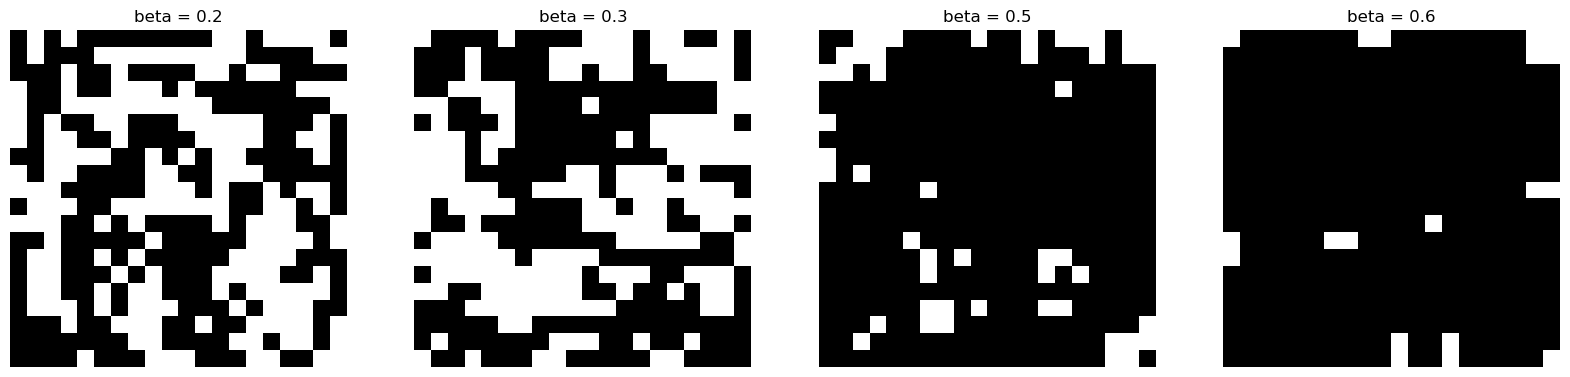

In [2]:
import matplotlib.pyplot as plt

def plot_ising_model_samples(L, M, betas):
    """
    Plot the Ising model samples for different values of beta.

    Args:
    - L (int): Size of the lattice.
    - M (int): Number of Gibbs sampling iterations.
    - betas (list of float): List of beta values to sample for.
    """
    fig, axs = plt.subplots(1, len(betas), figsize=(20, 5))

    for i, beta in enumerate(betas):
        # Run Gibbs sampling for the given beta
        sampled_lattice = gibbs_ising(M, beta, L)

        # Plotting
        axs[i].imshow(sampled_lattice, cmap='gray')
        axs[i].set_title(f"beta = {beta}")
        axs[i].axis('off')

    plt.show()

# Parameters
L = 20  # Size of the lattice
M = 5000  # Number of Gibbs sampling iterations
betas = [0.2, 0.3, 0.5, 0.6]  # Different beta values

# Generate and plot the samples
plot_ising_model_samples(L, M, betas)



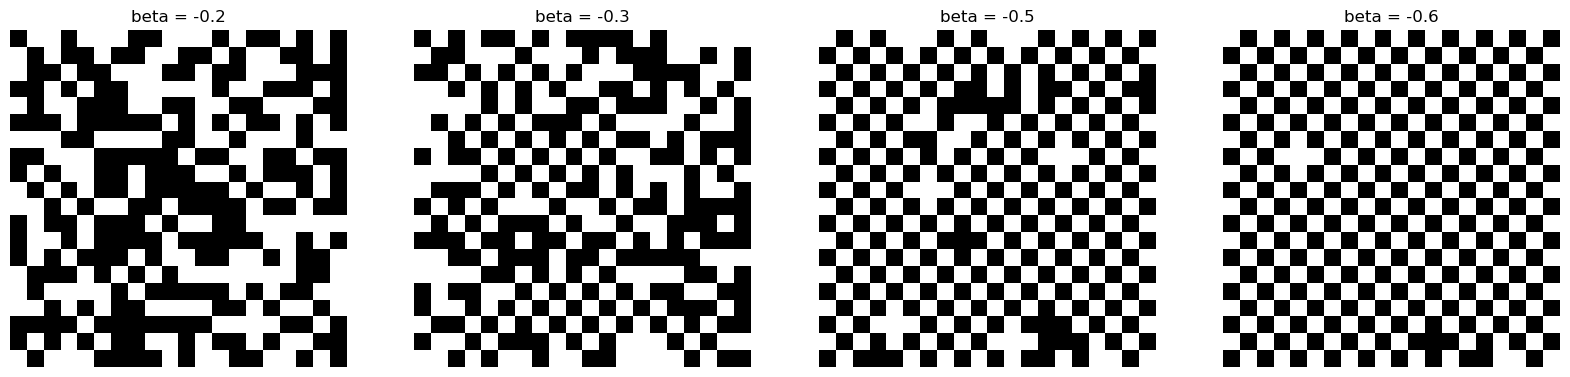

In [3]:
# Parameters
L = 20  # Size of the lattice
M = 5000  # Number of Gibbs sampling iterations
betas = [-0.2, -0.3, -0.5, -0.6]  # Different beta values

# Generate and plot the samples
plot_ising_model_samples(L, M, betas)

#### Bayesian denoising

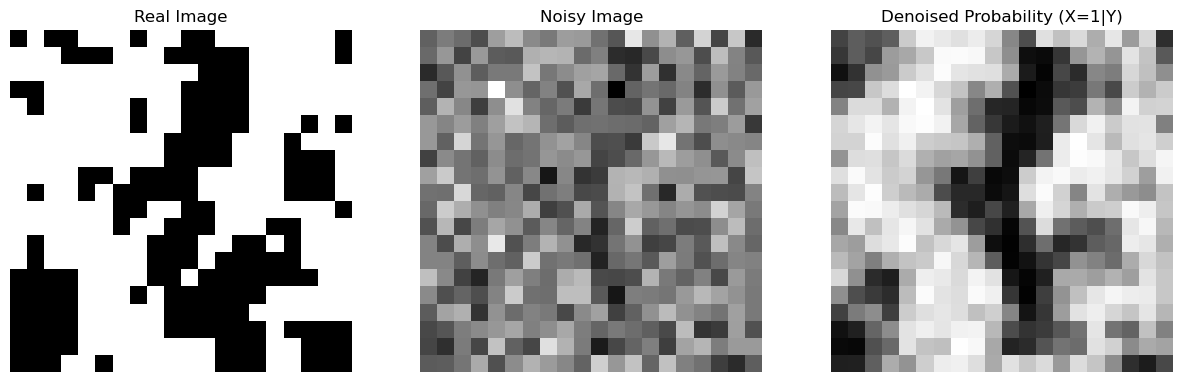

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def gibbs_denoise(M, beta, Y, sigma, burn_in=100):
    """
    Run Gibbs sampling for the Ising model.

    Args:
    - M (int): Number of samples to draw after burn-in.
    - beta (float): Inverse temperature parameter of the Ising model (prior).
    - Y (np.array): Observed noisy image (2D array).
    - sigma (float): Standard deviation of the noise.
    - burn_in (int, optional): Number of burn-in iterations. Default is 100.

    Returns:
    - np.array: Approximation of the probability of each pixel being +1 in the denoised image.
    """
    L = Y.shape[0]  # Size of the original image
    count = np.zeros((L, L))

    # Initialize a (L+2) x (L+2) grid with 0s and set the inner LxL grid to random -1 or +1
    X = np.zeros((L + 2, L + 2))
    X[1:L + 1, 1:L + 1] = np.random.choice([-1, 1], size=(L, L))

    for sweep in range(burn_in + M):
        for ix in range(1, L + 1):
            for iy in range(1, L + 1):
                d = X[iy - 1, ix] + X[iy + 1, ix] + X[iy, ix - 1] + X[iy, ix + 1]
                p = 1 / (1 + np.exp(-2 * (beta * d + Y[iy - 1, ix - 1] / sigma**2)))
                X[iy, ix] = np.random.choice([-1, 1], p=[1 - p, p])
        
        # Count the occurrences of +1s after the burn-in period
        if sweep >= burn_in:
            count += (X[1:L + 1, 1:L + 1] == 1)
    
    return count / M


# Example usage
L = 20  # Size of the image
N = 1000  # Number of samples to draw
beta = 0.4  # Inverse temperature
sigma = 2.0  # Standard deviation of noise

# Create a real binary image
real_X = gibbs_ising(M=1000, beta=0.4, L=20)

# Add Gaussian noise to create a noisy version
noisy_Y = real_X + np.random.normal(0, sigma, (L, L))


# Denoise using Gibbs sampling
# assuming using the same beta
denoised_probability = gibbs_denoise(M, beta, noisy_Y, sigma)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the real image
axs[0].imshow(real_X, cmap='gray')
axs[0].set_title("Real Image")
axs[0].axis('off')

# Plot the noisy image
axs[1].imshow(noisy_Y, cmap='gray')
axs[1].set_title("Noisy Image")
axs[1].axis('off')

# Plot the denoised probability
axs[2].imshow(denoised_probability, cmap='gray')
axs[2].set_title("Denoised Probability (X=1|Y)")
axs[2].axis('off')

plt.show()
